###Import dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deewakarchakraborty/portrait-paintings")

print("Path to dataset files:", path)

100%|██████████| 223M/223M [00:02<00:00, 95.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/deewakarchakraborty/portrait-paintings/versions/1


In [4]:
import os

dataset_path = '/root/.cache/kagglehub/datasets/deewakarchakraborty/portrait-paintings/versions/1'
files = os.listdir(dataset_path)

print(f"Files in dataset: {files[:10]}")  # Print first 10 files for example


Files in dataset: ['Images']


###1. List Files in the "Images" Folder

In [5]:
image_folder_path = os.path.join(dataset_path, 'Images')
image_files = os.listdir(image_folder_path)

print(f"Files in Images folder: {image_files[:10]}")  # Print first 10 image files


Files in Images folder: ['ferdinand-hodler_30.jpg', 'mahmoud-saiid_9.jpg', 'joan-brull_64.jpg', 'lovis-corinth_27.jpg', 'solomon-joseph-solomon_5.jpg', 'octav-bancila_0.jpg', 'richard-gerstl_7.jpg', 'pyotr-konchalovsky_30.jpg', 'carl-larsson_19.jpg', 'nikolay-bogdanov-belsky_32.jpg']


###2. Load and Display the First Image


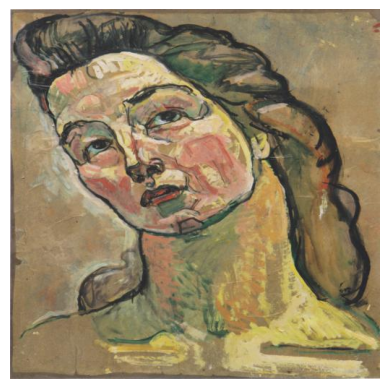

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the first image from the folder
image_path = os.path.join(image_folder_path, image_files[0])
image = Image.open(image_path)

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner view
plt.show()


###3. Preprocess the Images for GAN

In [12]:
import numpy as np

# Resize image to 128x128 (or any size that fits your GAN model)
image = image.resize((128, 128))

# Convert to numpy array
image_array = np.array(image)

# Normalize pixel values to [-1, 1]
image_array = (image_array / 127.5) - 1.0

# Display the processed image
Image.fromarray(((image_array + 1) * 127.5).astype(np.uint8)).show()


In [13]:
import tensorflow as tf

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Resize to 128x128
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Get paths to all image files in the "Images" folder
image_paths = [os.path.join(image_folder_path, f) for f in image_files]

# Create a dataset from the image paths
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = image_dataset.map(lambda x: load_and_preprocess_image(x))

# Shuffle and batch the dataset
image_dataset = image_dataset.shuffle(1000).batch(32)

# Preview the dataset (first batch of images)
for batch in image_dataset.take(1):
    print(batch.shape)


(32, 128, 128, 3)


###4.Define the Generator and Discriminator

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_shape=(100,)),  # Latent space (random noise)
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')  # RGB output
    ])
    return model

generator = build_generator()
generator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 3)         │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,344,675 (8.94 MB)

 Trainable params: 2,344,675 (8.94 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu', input_shape=(128, 128, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
        layers.Conv2D(256, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Output: Real or Fake
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          65,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 724,417 (2.76 MB)

 Trainable params: 724,417 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

### Loss Functions

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


###Optimizer

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

###5.Training Loop

In [18]:
import numpy as np

# Create a random latent space vector for the generator input
def generate_latent_space(batch_size):
    return np.random.normal(0, 1, size=(batch_size, 100))  # Latent space (noise)

# Training step for both models
@tf.function
def train_step(real_images):
    batch_size = real_images.shape[0]

    # Generate random noise for the generator
    noise = generate_latent_space(batch_size)

    # Generate fake images
    fake_images = generator(noise, training=True)

    # Train the discriminator
    with tf.GradientTape() as disc_tape:
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        # Calculate discriminator loss
        disc_loss = (cross_entropy(tf.ones_like(real_output), real_output) +
                     cross_entropy(tf.zeros_like(fake_output), fake_output)) / 2

    # Apply gradients to the discriminator
    grads_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)

        # Generator loss (want discriminator to be tricked)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Apply gradients to the generator
    grads_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))

    return disc_loss, gen_loss

# Number of epochs
epochs = 10
batch_size = 32

# Training loop
for epoch in range(epochs):
    for batch in image_dataset:
        disc_loss, gen_loss = train_step(batch)

    print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {disc_loss}, Generator Loss: {gen_loss}")


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/10, Discriminator Loss: 0.0019116905750706792, Generator Loss: 5.7459516525268555
Epoch 2/10, Discriminator Loss: 0.23080974817276, Generator Loss: 3.515562057495117
Epoch 3/10, Discriminator Loss: 0.221029132604599, Generator Loss: 1.5298876762390137
Epoch 4/10, Discriminator Loss: 0.580177903175354, Generator Loss: 1.1985844373703003
Epoch 5/10, Discriminator Loss: 0.5312628746032715, Generator Loss: 0.6900371313095093
Epoch 6/10, Discriminator Loss: 0.4829658269882202, Generator Loss: 2.0459907054901123
Epoch 7/10, Discriminator Loss: 0.2829369306564331, Generator Loss: 2.9220876693725586
Epoch 8/10, Discriminator Loss: 0.43733149766921997, Generator Loss: 1.1571693420410156
Epoch 9/10, Discriminator Loss: 0.24749794602394104, Generator Loss: 2.36068058013916
Epoch 10/10, Discriminator Loss: 0.33548256754875183, Generator Loss: 2.456697463989258


###6.Monitor Progress

In [19]:
def generate_and_save_images(epoch, model, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2  # Rescale images to [0, 1]
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig(f'generated_image_epoch_{epoch}.png')
    plt.close()

# Generate random noise for display
test_input = generate_latent_space(16)

# Save sample images after every epoch
for epoch in range(epochs):
    generate_and_save_images(epoch, generator, test_input)


###7.Save Model

In [20]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

In [27]:
# Generate random noise for display
test_input = tf.random.normal([16, 100])
# Visualize generated images
generate_and_save_images(10,generator, test_input)

###Display generated images

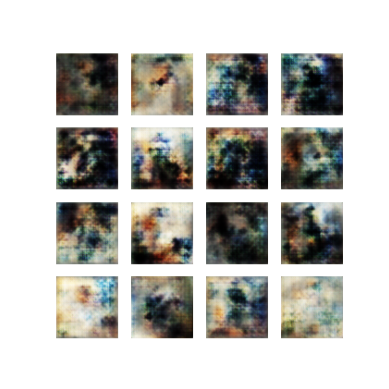

In [29]:
image_path = 'generated_image_epoch_10.png'
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner view
plt.show()